# 4 State Model Net Cycle Flux Testing

In [1]:
import os
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sympy import symbols, latex

from kda import plotting, graph_utils, calculations, diagrams, expressions, ode

## Define Rate Matrices

In [2]:
kvals1 = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
])

kvals2 = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [1, 1, 1, 0],
])

G1 = nx.MultiDiGraph()
graph_utils.generate_edges(G1, kvals1)
G2 = nx.MultiDiGraph()
graph_utils.generate_edges(G2, kvals2)
pos = {0 : [1, 1],
       1 : [-1, 1],
       2 : [-1, -1],
       3 : [1, -1]}

In [3]:
def save_figure(fig, filename):
    # get the current working directory for saving figures
    cwd = os.getcwd()
    for _ext in ("png", "svg", "pdf"):
        path = os.path.join(cwd, f"{filename}.{_ext}")
        fig.savefig(path, dpi=300)

## Plot Kinetic Diagrams

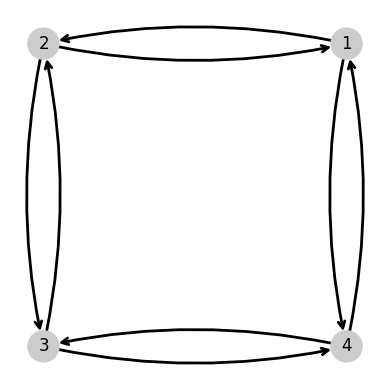

In [4]:
plotting.draw_diagrams(G1, pos=pos, font_size=12, curved_arrows=True)

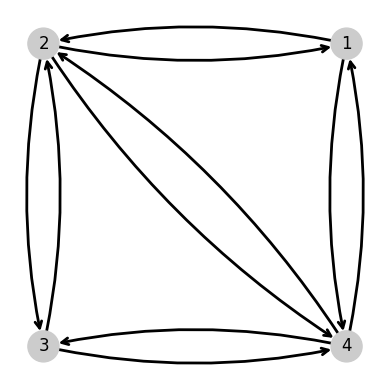

In [5]:
plotting.draw_diagrams(G2, pos=pos, font_size=12, curved_arrows=True)

## Generate Partial, Directional Diagrams

In [6]:
pars = diagrams.generate_partial_diagrams(G2)
dirpars = diagrams.generate_directional_diagrams(G2)

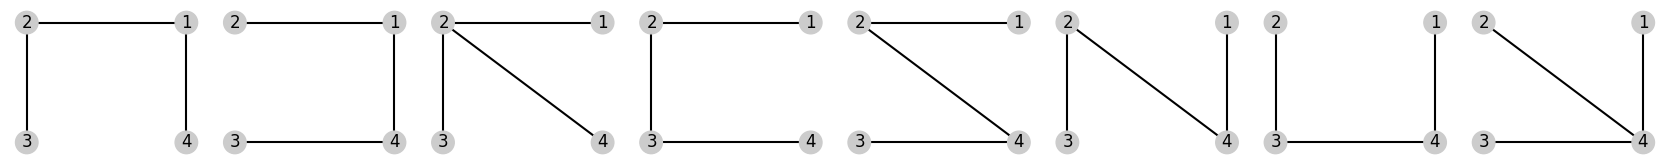

In [7]:
plotting.draw_diagrams(pars, pos=pos, panel=True, panel_scale=1.75, rows=1, cols=8, font_size=12)

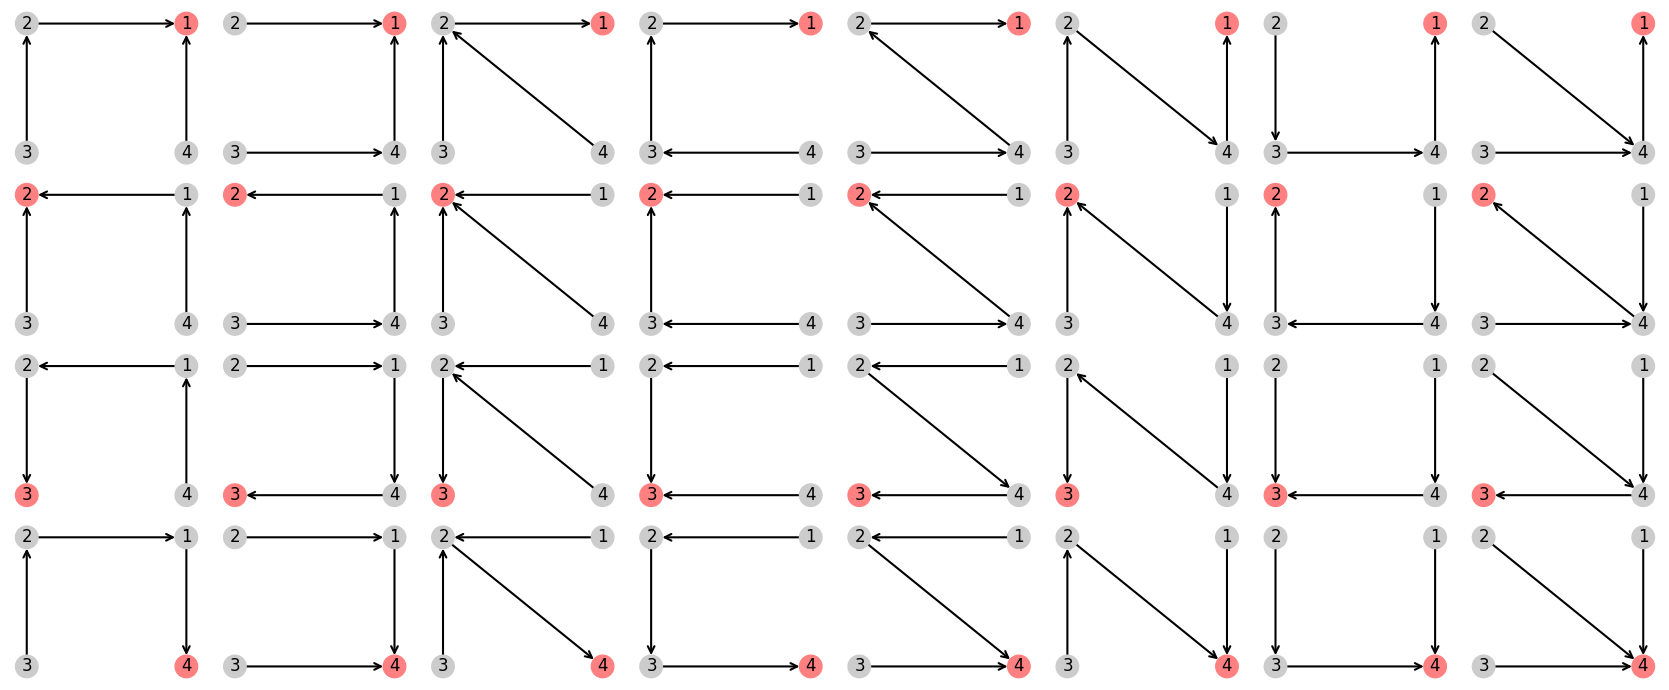

In [8]:
plotting.draw_diagrams(dirpars, pos=pos, panel=True, panel_scale=1.75, rows=4, font_size=12, cbt=True)

## Collect Cycles & Save Cycles Figure

Let's collect the cycles.

In [9]:
G1_cycle = graph_utils.find_all_unique_cycles(G1)[0]
G2_cycles = graph_utils.find_all_unique_cycles(G2)

The cycle directions have to be hand chosen. This is accomplished by putting, in order, any pair of nodes into a list. 

In [10]:
G1_order = [0, 1]
G2_orders = [[0, 1], [0, 1], [1, 2]]

Plot the cycles.

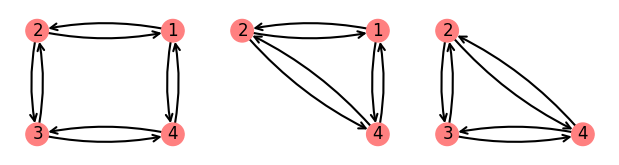

In [11]:
# G2_cycles_reordered = [G2_cycles[1], G2_cycles[0], G2_cycles[2]]
plotting.draw_cycles(G2, G2_cycles, pos=pos, panel=True, panel_scale=1.75, font_size=12, curved_arrows=True, cbt=True)

## Define Variable Substitution Maps

We need to start with defining `symbols` that SymPy can then use to substitute. Let's start by first defining all the rates in the more complex diagram, G2.

In [12]:
k12, k21, k23, k32, k34, k43, k41, k14, k24, k42 = symbols(
"k12, k21, k23, k32, k34, k43, k41, k14, k24, k42"
)

Now we need to define the variables we want to substitute, such as on/off rates, internal/external concentrations, etc. 

In [13]:
R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext = symbols(
    "R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext"
)

Now we can define our variable substitution maps. We will need 1 for each model. 

In [14]:
sub_dict1 = {
    k12: R_off,
    k21: R_on*R_int,
    k23: L_on*L_int,
    k32: L_off,
    k34: L_off,
    k43: L_on*L_ext,
    k41: R_on*R_ext,
    k14: R_off,
}

In [15]:
sub_dict2 = {
    k12: R_off,
    k21: R_on*R_int,
    k23: L_on*L_int,
    k32: L_off,
    k34: L_off,
    k43: L_on*L_ext,
    k41: R_on*R_ext,
    k14: R_off,
    k24: k_leak,
    k42: k_leak,
}

Lastly, we will define the final variable names to use for our lambda expressions.

In [16]:
rate_names1 = ["R_on, R_off, L_on, L_off, R_int, R_ext, L_int, L_ext"]
rate_names2 = ["R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext"]

## State Probability Expressions

In [17]:
G1_prob_strs = calculations.calc_state_probs(G1, key='name', output_strings=True)
G2_prob_strs = calculations.calc_state_probs(G2, key='name', output_strings=True)
p1_exp = G2_prob_strs[0]

In [18]:
p1_exp

(k21*k32*k41 + k21*k32*k42 + k21*k32*k43 + k21*k34*k41 + k21*k34*k42 + k23*k34*k41 + k24*k32*k41 + k24*k34*k41)/(k12*k23*k34 + k12*k23*k41 + k12*k23*k42 + k12*k23*k43 + k12*k24*k32 + k12*k24*k34 + k12*k24*k43 + k12*k32*k41 + k12*k32*k42 + k12*k32*k43 + k12*k34*k41 + k12*k34*k42 + k14*k21*k32 + k14*k21*k34 + k14*k21*k43 + k14*k23*k34 + k14*k23*k42 + k14*k23*k43 + k14*k24*k32 + k14*k24*k34 + k14*k24*k43 + k14*k32*k42 + k14*k32*k43 + k14*k34*k42 + k21*k32*k41 + k21*k32*k42 + k21*k32*k43 + k21*k34*k41 + k21*k34*k42 + k23*k34*k41 + k24*k32*k41 + k24*k34*k41)

In [19]:
latex(p1_exp)

'\\frac{k_{21} k_{32} k_{41} + k_{21} k_{32} k_{42} + k_{21} k_{32} k_{43} + k_{21} k_{34} k_{41} + k_{21} k_{34} k_{42} + k_{23} k_{34} k_{41} + k_{24} k_{32} k_{41} + k_{24} k_{34} k_{41}}{k_{12} k_{23} k_{34} + k_{12} k_{23} k_{41} + k_{12} k_{23} k_{42} + k_{12} k_{23} k_{43} + k_{12} k_{24} k_{32} + k_{12} k_{24} k_{34} + k_{12} k_{24} k_{43} + k_{12} k_{32} k_{41} + k_{12} k_{32} k_{42} + k_{12} k_{32} k_{43} + k_{12} k_{34} k_{41} + k_{12} k_{34} k_{42} + k_{14} k_{21} k_{32} + k_{14} k_{21} k_{34} + k_{14} k_{21} k_{43} + k_{14} k_{23} k_{34} + k_{14} k_{23} k_{42} + k_{14} k_{23} k_{43} + k_{14} k_{24} k_{32} + k_{14} k_{24} k_{34} + k_{14} k_{24} k_{43} + k_{14} k_{32} k_{42} + k_{14} k_{32} k_{43} + k_{14} k_{34} k_{42} + k_{21} k_{32} k_{41} + k_{21} k_{32} k_{42} + k_{21} k_{32} k_{43} + k_{21} k_{34} k_{41} + k_{21} k_{34} k_{42} + k_{23} k_{34} k_{41} + k_{24} k_{32} k_{41} + k_{24} k_{34} k_{41}}'

In [53]:
p1_simple = p1_exp.subs(sub_dict2).simplify()

In [54]:
p1_simple

L_off*R_on*(L_ext*L_on*R_int + L_int*L_on*R_ext + 2*R_ext*R_int*R_on + 2*R_ext*k_leak + 2*R_int*k_leak)/(2*L_ext*L_int*L_on**2*R_off + L_ext*L_off*L_on*R_int*R_on + 2*L_ext*L_off*L_on*R_off + L_ext*L_on*R_int*R_off*R_on + 2*L_ext*L_on*R_off*k_leak + L_int*L_off*L_on*R_ext*R_on + 2*L_int*L_off*L_on*R_off + L_int*L_on*R_ext*R_off*R_on + 2*L_int*L_on*R_off*k_leak + 2*L_off*R_ext*R_int*R_on**2 + 2*L_off*R_ext*R_off*R_on + 2*L_off*R_ext*R_on*k_leak + 2*L_off*R_int*R_off*R_on + 2*L_off*R_int*R_on*k_leak + 8*L_off*R_off*k_leak)

In [55]:
latex(p1_simple)

'\\frac{L_{off} R_{on} \\left(L_{ext} L_{on} R_{int} + L_{int} L_{on} R_{ext} + 2 R_{ext} R_{int} R_{on} + 2 R_{ext} k_{leak} + 2 R_{int} k_{leak}\\right)}{2 L_{ext} L_{int} L_{on}^{2} R_{off} + L_{ext} L_{off} L_{on} R_{int} R_{on} + 2 L_{ext} L_{off} L_{on} R_{off} + L_{ext} L_{on} R_{int} R_{off} R_{on} + 2 L_{ext} L_{on} R_{off} k_{leak} + L_{int} L_{off} L_{on} R_{ext} R_{on} + 2 L_{int} L_{off} L_{on} R_{off} + L_{int} L_{on} R_{ext} R_{off} R_{on} + 2 L_{int} L_{on} R_{off} k_{leak} + 2 L_{off} R_{ext} R_{int} R_{on}^{2} + 2 L_{off} R_{ext} R_{off} R_{on} + 2 L_{off} R_{ext} R_{on} k_{leak} + 2 L_{off} R_{int} R_{off} R_{on} + 2 L_{off} R_{int} R_{on} k_{leak} + 8 L_{off} R_{off} k_{leak}}'

## Net Cycle Flux Expression Manipulation

We will start with the net cycle flux for G1, since it only has 1 cycle.

In [23]:
J_G1_func = calculations.calc_net_cycle_flux(G1, G1_cycle, order=G1_order, key='name', output_strings=True)
J_G1 = J_G1_func.subs(sub_dict1).simplify()

Cycle [0, 1, 2, 3] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 2, 3]. Sigma K value is 1.


For G2, to assist with name keeping we will start with creating a dictionary containing the cycles and their respective functions.

In [24]:
# used for kda-paper
# J_a = calculations.calc_net_cycle_flux(G2, cycle=[0, 1, 2, 3], 
#     order=[0, 1], key="name", output_strings=True)
# J_a = J_a.subs(sub_dict2).simplify()
# latex(J_a)

In [25]:
cycle_dict = {}
for (label, cycle, order) in zip(["a", "b", "c"], G2_cycles, G2_orders):
    func = calculations.calc_net_cycle_flux(G2, cycle, order=order, key='name', output_strings=True)
    func = func.subs(sub_dict2).simplify()
    cycle_dict[label] = {
        "cycle": cycle, 
        "order": order, 
        "func": func}

Cycle [0, 1, 2, 3] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 1, 2, 3]. Sigma K value is 1.


In [26]:
latex(J_G1)

'\\frac{L_{off} L_{on} R_{off} R_{on} \\left(- L_{ext} R_{int} + L_{int} R_{ext}\\right)}{2 L_{ext} L_{int} L_{on}^{2} R_{off} + L_{ext} L_{off} L_{on} R_{int} R_{on} + 2 L_{ext} L_{off} L_{on} R_{off} + L_{ext} L_{on} R_{int} R_{off} R_{on} + L_{int} L_{off} L_{on} R_{ext} R_{on} + 2 L_{int} L_{off} L_{on} R_{off} + L_{int} L_{on} R_{ext} R_{off} R_{on} + 2 L_{off} R_{ext} R_{int} R_{on}^{2} + 2 L_{off} R_{ext} R_{off} R_{on} + 2 L_{off} R_{int} R_{off} R_{on}}'

In [27]:
cycle_dict["a"]["func"]

L_off*L_on*R_off*R_on*(-L_ext*R_int + L_int*R_ext)/(2*L_ext*L_int*L_on**2*R_off + L_ext*L_off*L_on*R_int*R_on + 2*L_ext*L_off*L_on*R_off + L_ext*L_on*R_int*R_off*R_on + 2*L_ext*L_on*R_off*k_leak + L_int*L_off*L_on*R_ext*R_on + 2*L_int*L_off*L_on*R_off + L_int*L_on*R_ext*R_off*R_on + 2*L_int*L_on*R_off*k_leak + 2*L_off*R_ext*R_int*R_on**2 + 2*L_off*R_ext*R_off*R_on + 2*L_off*R_ext*R_on*k_leak + 2*L_off*R_int*R_off*R_on + 2*L_off*R_int*R_on*k_leak + 8*L_off*R_off*k_leak)

In [56]:
latex(cycle_dict["a"]["func"])

'\\frac{L_{off} L_{on} R_{off} R_{on} \\left(- L_{ext} R_{int} + L_{int} R_{ext}\\right)}{2 L_{ext} L_{int} L_{on}^{2} R_{off} + L_{ext} L_{off} L_{on} R_{int} R_{on} + 2 L_{ext} L_{off} L_{on} R_{off} + L_{ext} L_{on} R_{int} R_{off} R_{on} + 2 L_{ext} L_{on} R_{off} k_{leak} + L_{int} L_{off} L_{on} R_{ext} R_{on} + 2 L_{int} L_{off} L_{on} R_{off} + L_{int} L_{on} R_{ext} R_{off} R_{on} + 2 L_{int} L_{on} R_{off} k_{leak} + 2 L_{off} R_{ext} R_{int} R_{on}^{2} + 2 L_{off} R_{ext} R_{off} R_{on} + 2 L_{off} R_{ext} R_{on} k_{leak} + 2 L_{off} R_{int} R_{off} R_{on} + 2 L_{off} R_{int} R_{on} k_{leak} + 8 L_{off} R_{off} k_{leak}}'

In [28]:
cycle_dict["b"]["func"]

2*L_off*R_off*R_on*k_leak*(R_ext - R_int)/(2*L_ext*L_int*L_on**2*R_off + L_ext*L_off*L_on*R_int*R_on + 2*L_ext*L_off*L_on*R_off + L_ext*L_on*R_int*R_off*R_on + 2*L_ext*L_on*R_off*k_leak + L_int*L_off*L_on*R_ext*R_on + 2*L_int*L_off*L_on*R_off + L_int*L_on*R_ext*R_off*R_on + 2*L_int*L_on*R_off*k_leak + 2*L_off*R_ext*R_int*R_on**2 + 2*L_off*R_ext*R_off*R_on + 2*L_off*R_ext*R_on*k_leak + 2*L_off*R_int*R_off*R_on + 2*L_off*R_int*R_on*k_leak + 8*L_off*R_off*k_leak)

In [29]:
cycle_dict["c"]["func"]

2*L_off*L_on*R_off*k_leak*(-L_ext + L_int)/(2*L_ext*L_int*L_on**2*R_off + L_ext*L_off*L_on*R_int*R_on + 2*L_ext*L_off*L_on*R_off + L_ext*L_on*R_int*R_off*R_on + 2*L_ext*L_on*R_off*k_leak + L_int*L_off*L_on*R_ext*R_on + 2*L_int*L_off*L_on*R_off + L_int*L_on*R_ext*R_off*R_on + 2*L_int*L_on*R_off*k_leak + 2*L_off*R_ext*R_int*R_on**2 + 2*L_off*R_ext*R_off*R_on + 2*L_off*R_ext*R_on*k_leak + 2*L_off*R_int*R_off*R_on + 2*L_off*R_int*R_on*k_leak + 8*L_off*R_off*k_leak)

## Operational Flux Expressions & Analysis

Since the net cycle flux for **G1** is the operational flux for **G1**, we do not need to do any arithmetic. In fact, any of the net transition fluxes are also equal to the operational flux:

$\begin{equation}
    J_{\text{a}} = J_{\text{R}} = J_{\text{L}} = J_{1,2} = J_{2,3} = J_{3,4} = J_{4,1}
\end{equation}$

For **G2**, we need to sum the relevant net cycle fluxes. Cycle **a** is a contributor to both **R** and **L** transport, while cycles **b** and **c** are contributors to only **R** and **L** transport, respectively. For this reason, the operational fluxes for **R** and **L** are expressed

$\begin{flalign}
    J_{\text{R}} &= J_{\text{a}} + J_{\text{b}} \\
    J_{\text{L}} &= J_{\text{a}} + J_{\text{c}}
\end{flalign}$

In [30]:
J_a = cycle_dict["a"]["func"]
J_b = cycle_dict["b"]["func"]
J_c = cycle_dict["c"]["func"]

J_R = (J_a + J_b).simplify()
J_L = (J_a + J_c).simplify()

As an aside, the operational fluxes are also equal to some of the net transition fluxes for this model.

$
\begin{flalign}
    J_{\text{R}} &= J_{\text{a}} + J_{\text{b}} = J_{1, 2} = J_{4, 1}\\
    J_{\text{L}} &= J_{\text{a}} + J_{\text{c}} = J_{2, 3} = J_{3, 4}
\end{flalign}
$

This means the operational flux expressions can be created from the state probability functions and rates: 

$
\begin{flalign}
    J_{\text{R}} &= J_{1, 2} = p_1 k_{1, 2} - p_2 k_{2, 1} \\
    J_{\text{L}} &= J_{2, 3} = p_2 k_{2, 3} - p_3 k_{3, 2}
\end{flalign}
$

In [31]:
p1, p2, p3, p4 = G2_prob_strs
J_R_trans = (p1.subs(sub_dict2) * sub_dict2[k12] - p2.subs(sub_dict2) * sub_dict2[k21]).simplify()
J_L_trans = (p2.subs(sub_dict2) * sub_dict2[k23] - p3.subs(sub_dict2) * sub_dict2[k32]).simplify()

Let's check if the expressions are in fact the same. SymPy uses the "==" operator for checking literal expression equality, so the recommended test is to subtract one from another and simplify. Identical expressions should simplify to zero. 

In [32]:
(J_R_trans - J_R).simplify() == 0

True

In [33]:
(J_L_trans - J_L).simplify() == 0

True

## Analysis

First we have to convert our SymPy expressions to lambda functions. 

In [34]:
# to calculate the flux for cycle a for both models
J_G1_lambda = expressions.construct_lambda_funcs(J_G1, rate_names1)
J_a_G2_lambda = expressions.construct_lambda_funcs(cycle_dict["a"]["func"], rate_names2)

# to calculate the operational fluxes for both ligands
J_R_lambda, J_L_lambda = expressions.construct_lambda_funcs([J_R, J_L], rate_names2)

Now we need to define our concentrations, binding/unbinding rates, and create an array of values to plot over. In this case we will be plotting over the leakage rate to see how it affects turnover. 

In [35]:
# binding/unbinding rates
R_on = 1e10
R_off = 1e3
L_on = 1e9
L_off = 1e2

# internal/external concentrations
# R_ext / R_int = 10
R_int = 10 ** (-7.5)
R_ext = 10 ** (-6.5)
# L_ext / L_int = 0.631
L_int = 10 ** (-6.9)
L_ext = 10 ** (-7.1)

# create an array of leakage values
leak_arr = np.logspace(-2, 2, 101)

With our values defined, we need to calculate the operational fluxes for all 3 cases across all value ranges. 

In [36]:
G1_arr = np.zeros(shape=(leak_arr.size,), dtype=np.float64)
G2_arr = np.zeros(shape=(leak_arr.size,), dtype=np.float64)
J_R_arr = np.zeros(shape=(leak_arr.size,), dtype=np.float64)
J_L_arr = np.zeros(shape=(leak_arr.size,), dtype=np.float64)

for i, k_leak in enumerate(leak_arr):
    G1_arr[i] = J_G1_lambda(R_on, R_off, L_on, L_off, R_int, R_ext, L_int, L_ext)
    G2_arr[i] = J_a_G2_lambda(R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext)    
    J_R_arr[i] = J_R_lambda(R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext)
    J_L_arr[i] = J_L_lambda(R_on, R_off, L_on, L_off, k_leak, R_int, R_ext, L_int, L_ext)

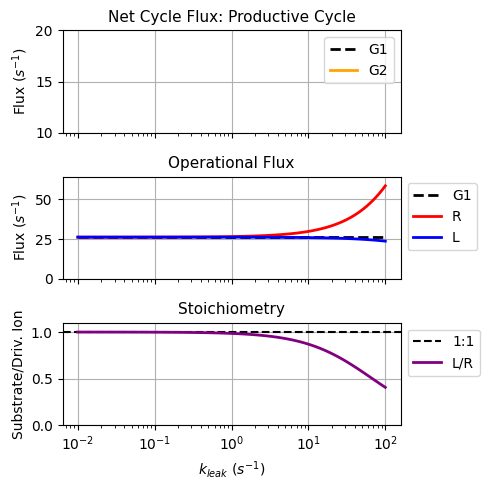

In [37]:
fig, axs = plt.subplots(3, figsize=(5, 5), sharex=True, tight_layout=True)

axs[0].semilogx(leak_arr, G1_arr, '--', lw=2, color="black", label="G1")
axs[0].semilogx(leak_arr, G2_arr, '-', lw=2, color="orange", label="G2")
axs[0].set_title("Net Cycle Flux: Productive Cycle", fontsize=11)
axs[0].set_ylabel(r"Flux ($s^{-1}$)", fontsize=10)
axs[0].set_ylim(10, 20)
axs[0].legend(bbox_to_anchor=(1, 1))
axs[0].grid(True)

axs[1].semilogx(leak_arr, G1_arr, '--', lw=2, color="black", label="G1")
axs[1].semilogx(leak_arr, J_R_arr, '-', color='red', lw=2, label=r"R")
axs[1].semilogx(leak_arr, J_L_arr, '-', color='blue', lw=2, label=r"L")
axs[1].set_title("Operational Flux", fontsize=11)
axs[1].set_ylabel(r"Flux ($s^{-1}$)", fontsize=10)
axs[1].set_ylim(0, np.max(J_R_arr)*1.1)
axs[1].legend(bbox_to_anchor=(1, 1))
axs[1].grid(True)

axs[2].axhline(y=1, ls='--', color='black', label="1:1")
axs[2].semilogx(leak_arr, J_L_arr/J_R_arr, '-', lw=2, color="purple", label=r"L/R")
axs[2].set_title("Stoichiometry", fontsize=11)
axs[2].set_ylabel("Substrate/Driv. Ion", fontsize=10)
axs[2].set_xlabel(r"$k_{leak}$ ($s^{-1}$)")
axs[2].set_ylim(0, 1.1)
axs[2].legend(bbox_to_anchor=(1, 1))
axs[2].grid(True)
# plt.savefig(cwd+"/4wl_all_in_one_plot.png", dpi=300)